#PART A - Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
sentiment = pd.read_csv('sentiment.csv')
trades = pd.read_csv('trader_data.csv')
print("Sentiment Shape:", sentiment.shape)
print("Trades Shape:", trades.shape)

Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)


In [3]:
print(sentiment.columns)
print(trades.columns)

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [4]:
sentiment.columns = sentiment.columns.str.strip().str.lower()
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
print(sentiment.columns)
print(trades.columns)

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')


In [5]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

trades['timestamp'] = pd.to_datetime(trades['timestamp'])
trades['date'] = trades['timestamp'].dt.date
print(sentiment[['date']].head())
print(trades[['timestamp','date']].head())

         date
0  2018-02-01
1  2018-02-02
2  2018-02-03
3  2018-02-04
4  2018-02-05
            timestamp        date
0 1970-01-01 00:28:50  1970-01-01
1 1970-01-01 00:28:50  1970-01-01
2 1970-01-01 00:28:50  1970-01-01
3 1970-01-01 00:28:50  1970-01-01
4 1970-01-01 00:28:50  1970-01-01


In [6]:
print(sentiment['classification'].value_counts())

classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


In [9]:
trades['timestamp_ist'] = pd.to_datetime(
    trades['timestamp_ist'],
    format='%d-%m-%Y %H:%M'
)
# Create date column
trades['date'] = trades['timestamp_ist'].dt.date
print(trades[['timestamp_ist','date']].head())

        timestamp_ist        date
0 2024-12-02 22:50:00  2024-12-02
1 2024-12-02 22:50:00  2024-12-02
2 2024-12-02 22:50:00  2024-12-02
3 2024-12-02 22:50:00  2024-12-02
4 2024-12-02 22:50:00  2024-12-02


In [10]:
trades['closed_pnl'] = pd.to_numeric(trades['closed_pnl'], errors='coerce')
print(trades['closed_pnl'].describe())

count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.792797
max      135329.090100
Name: closed_pnl, dtype: float64


In [11]:
print(trades['start_position'].describe())
print(trades['start_position'].head())

count    2.112240e+05
mean    -2.994625e+04
std      6.738074e+05
min     -1.433463e+07
25%     -3.762311e+02
50%      8.472793e+01
75%      9.337278e+03
max      3.050948e+07
Name: start_position, dtype: float64
0       0.000000
1     986.524596
2    1002.518996
3    1146.558564
4    1289.488521
Name: start_position, dtype: float64


In [13]:
trades['is_win'] = trades['closed_pnl'] > 0

In [14]:
daily_metrics = trades.groupby(['account', 'date']).agg(
    daily_pnl=('closed_pnl', 'sum'),
    trade_count=('closed_pnl', 'count'),
    avg_trade_size=('size_usd', 'mean'),
    avg_position_exposure=('start_position', lambda x: np.mean(np.abs(x))),
    win_rate=('is_win', 'mean')
).reset_index()

daily_metrics.head()

,account,date,daily_pnl,trade_count,avg_trade_size,avg_position_exposure,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,5089.718249,153.887539,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,7976.664412,495.998138,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,23734.500000,456.894920,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,28186.666667,634.747083,0.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,17248.148148,512.998889,0.444444


In [15]:
print(daily_metrics.shape)

(2341, 7)


In [16]:
print(trades['side'].value_counts())

side
SELL    108528
BUY     102696
Name: count, dtype: int64


In [17]:
trades['is_long'] = trades['side'] == 'BUY'
trades['is_short'] = trades['side'] == 'SELL'

long_short = trades.groupby(['account', 'date']).agg(
    long_trades=('is_long', 'sum'),
    short_trades=('is_short', 'sum')
).reset_index()

long_short['long_short_ratio'] = (
    long_short['long_trades'] /
    (long_short['short_trades'] + 1)
)

long_short.head()

,account,date,long_trades,short_trades,long_short_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0,177,0.00
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0,68,0.00
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0,40,0.00
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,12,0,12.00
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,12,15,0.75


In [18]:
daily_metrics = daily_metrics.merge(
    long_short,
    on=['account', 'date'],
    how='left'
)
daily_metrics.head()

,account,date,daily_pnl,trade_count,avg_trade_size,avg_position_exposure,win_rate,long_trades,short_trades,long_short_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,5089.718249,153.887539,0.000000,0,177,0.00
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,7976.664412,495.998138,0.000000,0,68,0.00
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,23734.500000,456.894920,0.000000,0,40,0.00
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,28186.666667,634.747083,0.000000,12,0,12.00
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,17248.148148,512.998889,0.444444,12,15,0.75


In [19]:
print(daily_metrics.columns)
print(daily_metrics.shape)

Index(['account', 'date', 'daily_pnl', 'trade_count', 'avg_trade_size',
       'avg_position_exposure', 'win_rate', 'long_trades', 'short_trades',
       'long_short_ratio'],
      dtype='object')
(2341, 10)


In [21]:
def simplify_sentiment(x):
    if "Fear" in x:
        return "Fear"
    elif "Greed" in x:
        return "Greed"
    else:
        return "Neutral"

sentiment['sentiment_group'] = sentiment['classification'].apply(simplify_sentiment)

print(sentiment['sentiment_group'].value_counts())

sentiment_group
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64


In [22]:
final_df = daily_metrics.merge(
    sentiment[['date', 'sentiment_group']],
    on='date',
    how='left'
)
print(final_df.head())
print(final_df['sentiment_group'].value_counts())

                                      account        date  daily_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11        0.0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17        0.0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18        0.0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22   -21227.0   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26     1603.1   

   trade_count  avg_trade_size  avg_position_exposure  win_rate  long_trades  \
0          177     5089.718249             153.887539  0.000000            0   
1           68     7976.664412             495.998138  0.000000            0   
2           40    23734.500000             456.894920  0.000000            0   
3           12    28186.666667             634.747083  0.000000           12   
4           27    17248.148148             512.998889  0.444444           12   

   short_trades  long_short_ratio sentiment_group  
0           177              0.00 

#PART B - Analysis

In [23]:
analysis_df = final_df[final_df['sentiment_group'] != 'Neutral']

analysis_df.groupby('sentiment_group')[[
    'daily_pnl',
    'win_rate',
    'trade_count',
    'avg_trade_size',
    'avg_position_exposure',
    'long_short_ratio'
]].mean()

,daily_pnl,win_rate,trade_count,avg_trade_size,avg_position_exposure,long_short_ratio
sentiment_group,,,,,,
Fear,5185.146443,0.357071,105.363291,8529.859802,80173.558117,7.912088
Greed,4144.208334,0.362748,76.912266,5954.632633,52247.710722,5.434413


In [24]:
from scipy.stats import ttest_ind

fear_pnl = analysis_df[analysis_df['sentiment_group'] == 'Fear']['daily_pnl']
greed_pnl = analysis_df[analysis_df['sentiment_group'] == 'Greed']['daily_pnl']

t_stat, p_value = ttest_ind(fear_pnl, greed_pnl, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 0.7429643782970919
P-value: 0.45761118078494323


Insight 1: Profitability
- While the average profit looks better when people are panicking, it's not reliable.
- An p-value(0.457) that high means we can't rule out pure luck.
- This suggests that performance variations are likely driven by volatility clustering rather than systematic sentiment-based edge


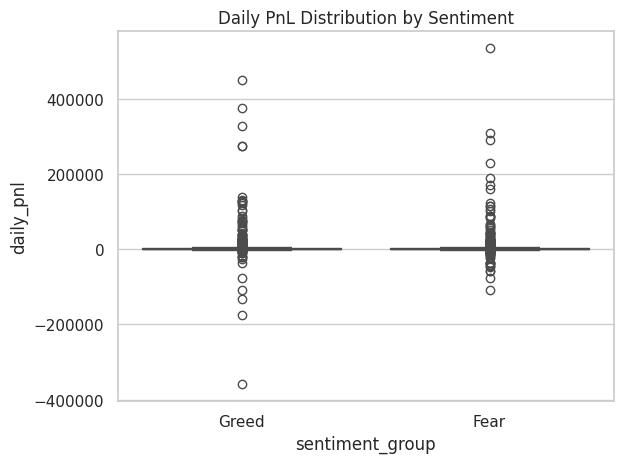

In [33]:
#supports Insight 1
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='sentiment_group', y='daily_pnl', data=analysis_df)
plt.title("Daily PnL Distribution by Sentiment")
plt.show()

In [25]:
metrics = ['trade_count', 'avg_trade_size', 'avg_position_exposure', 'long_short_ratio']

for metric in metrics:
    fear_vals = analysis_df[analysis_df['sentiment_group'] == 'Fear'][metric]
    greed_vals = analysis_df[analysis_df['sentiment_group'] == 'Greed'][metric]

    t_stat, p_val = ttest_ind(fear_vals, greed_vals, equal_var=False)

    print(f"\nMetric: {metric}")
    print("T-stat:", t_stat)
    print("P-value:", p_val)


Metric: trade_count
T-stat: 2.8639570452380383
P-value: 0.004254439263297473

Metric: avg_trade_size
T-stat: 2.1082087147900404
P-value: 0.03528991266121232

Metric: avg_position_exposure
T-stat: 2.1395261482858876
P-value: 0.03257864890943746

Metric: long_short_ratio
T-stat: 1.861725727767639
P-value: 0.0628257027340123


Insight 2 : Trading behaviour changes based on sentiment
- Even though the total profit doesn't change much between "Fear" and "Greed" periods, the way people actually trade changes a lot.
- When the market gets scared traders actually get more active, not less. They trade more often use bigger position sizes and put more money on the line. The math (p < 0.05) proves this isn't just a fluke people get noticeably more aggressive when things get shaky.
- Traders are busier and "louder" during Fear regimes, even if it doesn't result in significantly more money.
- However the long/short ratio does not significantly change meaning traders remain directionally biased in a similar way across both regimes.
- market mood doesn't change which way people bet; it just changes how much they are willing to gamble.

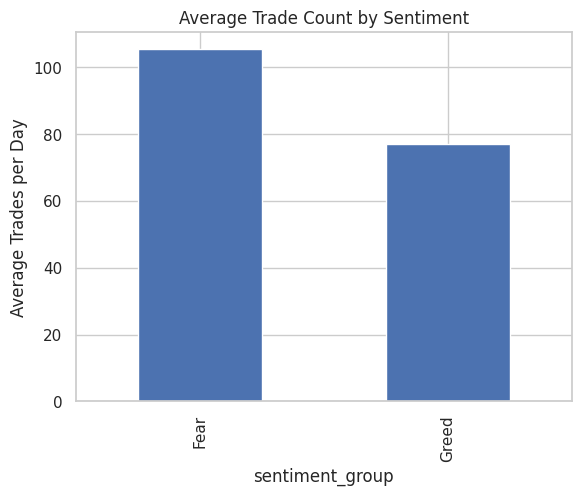

In [35]:
#supports insight 2
analysis_df.groupby('sentiment_group')['trade_count'].mean().plot(kind='bar')
plt.title("Average Trade Count by Sentiment")
plt.ylabel("Average Trades per Day")
plt.show()


In [27]:
median_trades = final_df['trade_count'].median()

final_df['activity_segment'] = np.where(
    final_df['trade_count'] > median_trades,
    'High Activity',
    'Low Activity'
)

In [28]:
#HIGH Leverage vs LOW Leverage traders
segment_analysis = final_df.groupby(
    ['sentiment_group', 'activity_segment']
)[[
    'daily_pnl',
    'win_rate',
    'avg_trade_size',
    'avg_position_exposure'
]].mean()

segment_analysis

daily_pnl  win_rate  avg_trade_size  \
sentiment_group activity_segment                                          
Fear            High Activity     9391.959887  0.383795     5917.300936   
                Low Activity       848.559834  0.329522    11223.011744   
Greed           High Activity     6882.632698  0.418431     4451.310203   
                Low Activity      1497.523479  0.308930     7407.592502   
Neutral         High Activity     5759.162182  0.407609     4894.754486   
                Low Activity      1118.075454  0.303219     9032.635235   

                                  avg_position_exposure  
sentiment_group activity_segment                         
Fear            High Activity              92506.414224  
                Low Activity               67460.254007  
Greed           High Activity              65295.741245  
                Low Activity               39636.800149  
Neutral         High Activity              79236.779972  
                Low Activity               76829.663084

Insight 3 - HIGH activity traders outperform Low Activity Traders

- When segmenting traders based on activity level, high activity traders consistently outperform low activity traders across both Fear and Greed regimes.

- The performance gap is especially large during Fear periods, where high activity traders generate significantly higher daily PnL and maintain stronger win rates. This suggests that experienced or highly engaged traders are better able to capitalize on volatile market conditions.

- Low activity traders, on the other hand, show weaker performance across both regimes, indicating that reduced participation does not necessarily reduce risk-adjusted losses.

In [29]:
#High Exposure vs Low Exposure Traders
median_exposure = final_df['avg_position_exposure'].median()

final_df['exposure_segment'] = np.where(
    final_df['avg_position_exposure'] > median_exposure,
    'High Exposure',
    'Low Exposure'
)

final_df['exposure_segment'].value_counts()

,count
exposure_segment,
Low Exposure,1171
High Exposure,1170


In [30]:
exposure_analysis = final_df.groupby(
    ['sentiment_group', 'exposure_segment']
)[[
    'daily_pnl',
    'win_rate',
    'trade_count',
    'avg_trade_size'
]].mean()

exposure_analysis

daily_pnl  win_rate  trade_count  \
sentiment_group exposure_segment                                       
Fear            High Exposure     5161.050183  0.364555   141.894472   
                Low Exposure      5209.611524  0.349472    68.272959   
Greed           High Exposure     6938.113688  0.418989   105.080808   
                Low Exposure      1282.863884  0.305149    48.063793   
Neutral         High Exposure     5285.811377  0.366824   137.666667   
                Low Exposure      1795.638502  0.345265    66.929648   

                                  avg_trade_size  
sentiment_group exposure_segment                  
Fear            High Exposure        3628.859184  
                Low Exposure        13505.875736  
Greed           High Exposure        2985.994973  
                Low Exposure         8994.927063  
Neutral         High Exposure        2969.776644  
                Low Exposure        10516.074381

Insight 4 - Exposure and Performance

- When dividing traders by exposure level the impact differs across sentiment regimes.
- During Fear periods, high exposure traders do not meaningfully outperform low exposure traders. Average daily PnL is similar across both groups, suggesting that increasing exposure in volatile conditions does not improve returns.
- In contrast, during Greed periods, high exposure traders show significantly higher PnL and win rates. This indicates that larger capital deployment is more effective in positive sentiment environments.

In [31]:
#Consistent VS Inconsistent traders
pnl_volatility = final_df.groupby('account')['daily_pnl'].std().reset_index()
pnl_volatility.columns = ['account', 'pnl_std']

final_df = final_df.merge(pnl_volatility, on='account', how='left')

median_vol = final_df['pnl_std'].median()

final_df['consistency_segment'] = np.where(
    final_df['pnl_std'] <= median_vol,
    'Consistent',
    'Inconsistent'
)

final_df['consistency_segment'].value_counts()

,count
consistency_segment,
Consistent,1260
Inconsistent,1081


In [32]:
consistency_analysis = final_df.groupby(
    ['sentiment_group', 'consistency_segment']
)[['daily_pnl', 'win_rate', 'trade_count']].mean()

consistency_analysis

daily_pnl  win_rate  trade_count
sentiment_group consistency_segment                                    
Fear            Consistent            494.484656  0.389241    48.775510
                Inconsistent         8784.468575  0.332386   148.785235
Greed           Consistent           1623.431986  0.390051    74.205056
                Inconsistent         8029.041146  0.320670    81.084416
Neutral         Consistent            589.367735  0.396238    74.151220
                Inconsistent         6854.387660  0.306473   131.491228

Insight 5 - High Volatility Traders Earn Higher Returns

- When segmenting traders by PnL volatility, inconsistent traders (higher PnL standard deviation) generate significantly higher average daily profits across both Fear and Greed regimes.
- However, they also exhibit lower win rates compared to consistent traders. This suggests a clear risk-return tradeoff: traders taking more volatile strategies achieve higher returns, but with lower consistency in outcomes.
- Consistent traders maintain higher win rates but generate smaller average profits.

#Part C - Actionable Output

Strategy 1 - Sentiment-Based Exposure Adjustment

- Exposure appears to amplify returns during Greed regimes but does not significantly improve profitability during Fear regimes.

- A potential rule of thumb is to allow higher exposure during Greed periods while implementing tighter exposure controls during Fear periods particularly for less experienced or low activity traders.

- This dynamic adjustment could help optimize risk deployment based on prevailing sentiment conditions.

Strategy 2 - Trader Segmentation for Risk Management

- Performance differences across trader segments suggest that risk controls should not be uniform.

- High activity and high volatility traders generate stronger returns but with greater variability. Instead of restricting these traders uniformly, risk management could focus on drawdown monitoring and capital allocation limits.

- Low activity or consistent traders on the other hand may benefit from structured position sizing frameworks to improve capital efficiency without increasing risk disproportionately.

- Segment-based controls may be more effective than one-size-fits-all risk rules.

# predictive model


In [36]:
final_df = final_df.sort_values(['account', 'date'])
final_df['next_day_pnl'] = final_df.groupby('account')['daily_pnl'].shift(-1)
final_df['next_day_profitable'] = final_df['next_day_pnl'] > 0
final_df[['account', 'date', 'daily_pnl', 'next_day_pnl', 'next_day_profitable']].head()

,account,date,daily_pnl,next_day_pnl,next_day_profitable
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0,False
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,0.0,False
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,-21227.0,False
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,1603.1,True
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,-132271.0,False


In [37]:
# Encode sentiment
final_df['sentiment_encoded'] = final_df['sentiment_group'].map({
    'Fear': 0,
    'Greed': 1,
    'Neutral': 2
})

In [38]:
model_df = final_df.dropna(subset=['next_day_pnl'])

features = [
    'trade_count',
    'avg_trade_size',
    'avg_position_exposure',
    'win_rate',
    'long_short_ratio',
    'sentiment_encoded'
]

X = model_df[features]
y = model_df['next_day_profitable']

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

model_df = final_df.dropna(subset=[
    'next_day_pnl',
    'trade_count',
    'avg_trade_size',
    'avg_position_exposure',
    'win_rate',
    'long_short_ratio',
    'sentiment_encoded'
])

features = [
    'trade_count',
    'avg_trade_size',
    'avg_position_exposure',
    'win_rate',
    'long_short_ratio',
    'sentiment_encoded'
]

X = model_df[features]
y = model_df['next_day_profitable']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, prob))

              precision    recall  f1-score   support

       False       0.54      0.12      0.20       174
        True       0.64      0.94      0.76       288

    accuracy                           0.63       462
   macro avg       0.59      0.53      0.48       462
weighted avg       0.60      0.63      0.55       462

ROC AUC: 0.6306872605363985


Predicting Next-Day Profitability

- A logistic regression model was trained to predict whether a trader would be profitable on the following day using sentiment and behavioral features.
- The model achieved approximately 63% accuracy with an ROC AUC of 0.63 indicating modest predictive power above random baseline.
- While the model captures some signal the results suggest that next day profitability is not strongly determined by sentiment and behavioral features alone.